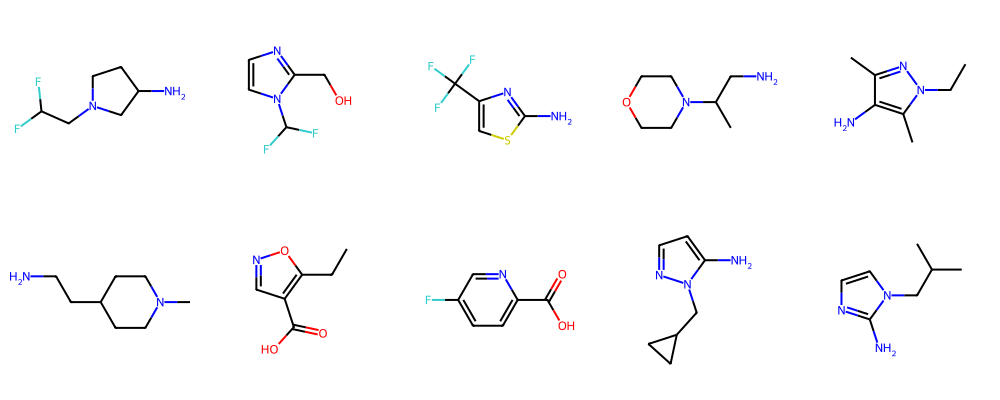

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

from druglab.storage import MolStorage, RxnStorage

mols = MolStorage()
mols.load_mols("EnamineHighFidelityFragments.sdf")

rxns = RxnStorage()
rxns.load_rxns("comprehensive.txt")

Draw.MolsToGridImage(mols.objects[:10], molsPerRow=5)

 99%|█████████▉| 114/115 [00:02<00:00, 52.47it/s]


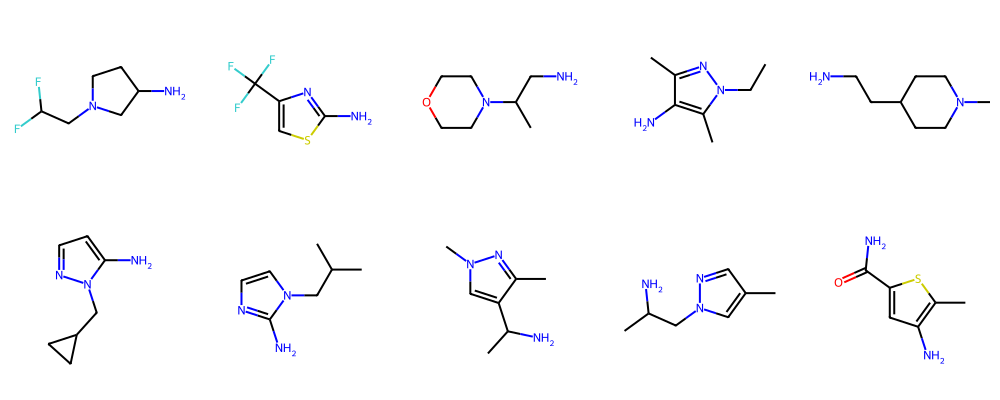

In [2]:
mid2rxnrids = rxns.match_mols(mols)
mols = mols.subset(list(mid2rxnrids.keys()))
rxns.add_mols(mols)
rxns.clean()

Draw.MolsToGridImage(mols.objects[:10], molsPerRow=5)

In [3]:
import random

from rdkit.Chem import QED
from rdkit import rdBase
rdBase.DisableLog("rdApp.*")

from druglab.synthesis import SynRouteSampler

import time

tic = time.time()
routes = SynRouteSampler(n_template_batch=200, 
                         n_route_batch=100).sample(rxns, num_processes=8)
toc = time.time()

keep_idx = [i for i, route in enumerate(routes)
            if QED.qed(route.products[-1])>0.7]
routes.subset(keep_idx, inplace=True)
random.shuffle(routes)
routes, toc-tic

100%|██████████| 200/200 [00:11<00:00, 19.83it/s]


[SynthesisRoute(seq=16, reactants=3, reactions=4, products=4), SynthesisRoute(seq=16, reactants=3, reactions=4, products=4), SynthesisRoute(seq=16, reactants=3, reactions=4, products=4), SynthesisRoute(seq=19, reactants=6, reactions=4, products=4), SynthesisRoute(seq=17, reactants=4, reactions=4, products=4), SynthesisRoute(seq=18, reactants=5, reactions=4, products=4), SynthesisRoute(seq=18, reactants=5, reactions=4, products=4), SynthesisRoute(seq=17, reactants=4, reactions=4, products=4), SynthesisRoute(seq=17, reactants=4, reactions=4, products=4), SynthesisRoute(seq=18, reactants=5, reactions=4, products=4), SynthesisRoute(seq=16, reactants=3, reactions=4, products=4), SynthesisRoute(seq=15, reactants=2, reactions=4, products=4), SynthesisRoute(seq=17, reactants=4, reactions=4, products=4), SynthesisRoute(seq=18, reactants=5, reactions=4, products=4), SynthesisRoute(seq=15, reactants=2, reactions=4, products=4), SynthesisRoute(seq=18, reactants=5, reactions=4, products=4), Synthes

(SynRouteStorage(1709 objects, 0 feats), 21.39057159423828)

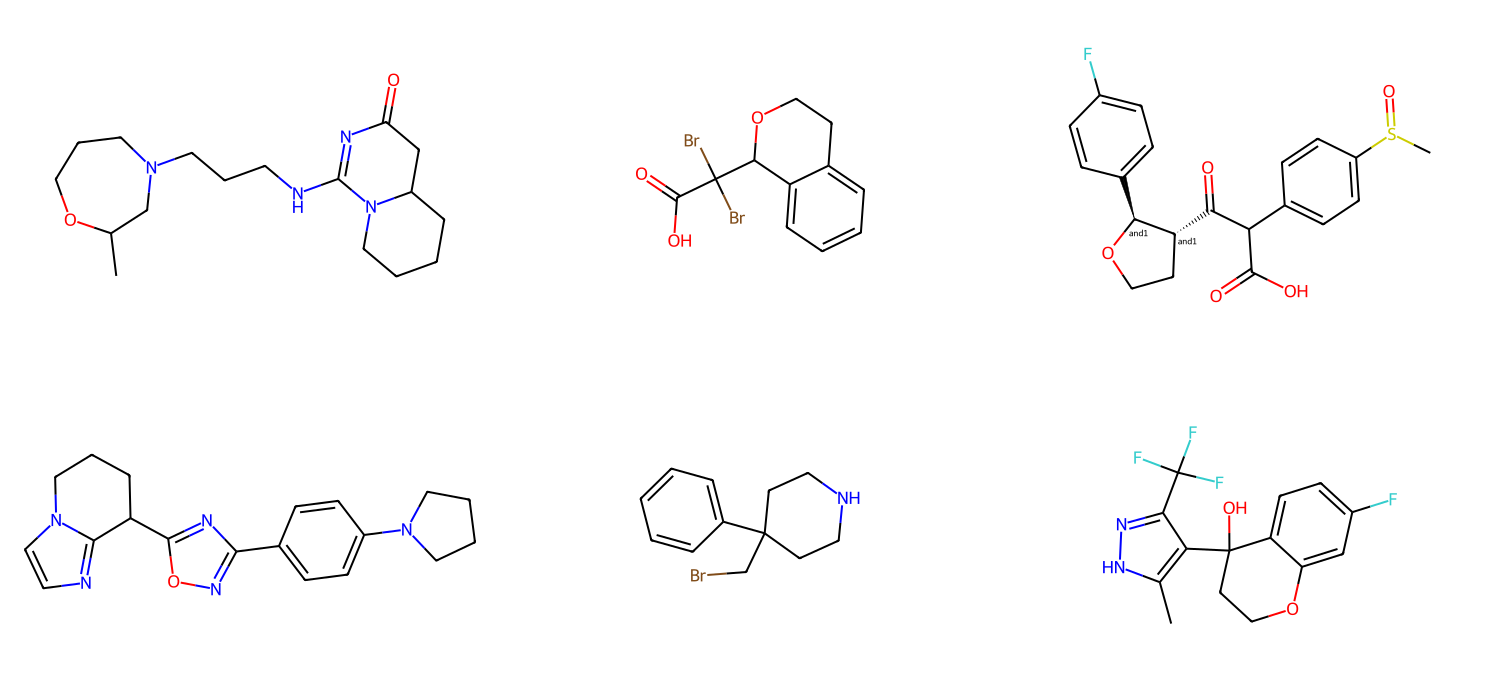

In [5]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

stid = 0
IPythonConsole.ShowMols([rou.products[-1] for rou in routes[stid:stid+6]],
                        subImgSize=(500, 350),
                        molsPerRow=3)

In [15]:
len([r for r in routes if len(r.reactions)>2])

393

In [16]:
from urllib.request import urlretrieve
import os, zipfile

forced = False

if not os.path.exists("./afrodb.zip") or forced:
    urlretrieve(
        ("https://coconut.s3.uni-jena.de/prod/downloads/2025-04/collections/afrodb-04-2025.zip"),
        "./afrodb.zip"
    )

if not os.path.exists("./afrodb.sdf") or forced:
    with zipfile.ZipFile("./afrodb.zip", "r") as zip_ref:
        zip_ref.extractall("./")
    os.rename("./afrodb-04-2025.sdf", "./afrodb.sdf")

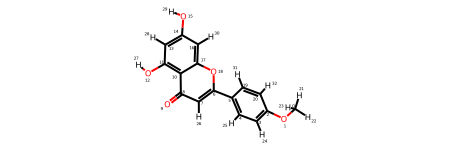

In [17]:
from rdkit import Chem
from rdkit.Chem import rdDistGeom, rdForceFieldHelpers
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

ref = list(Chem.SDMolSupplier("./afrodb.sdf"))[0]
ref = Chem.AddHs(ref)
rdDistGeom.EmbedMolecule(ref)
rdForceFieldHelpers.MMFFOptimizeMolecule(ref)
ref

In [18]:
from mpire import WorkerPool

from druglab.synthesis import SynthesisRoute

def prepare(route: SynthesisRoute):
    mol = route.products[-1]
    mol = Chem.AddHs(mol)
    suc = rdDistGeom.EmbedMolecule(mol)
    if suc == 0:
        rdForceFieldHelpers.MMFFOptimizeMolecule(mol)
    else:
        return None
    route.products[-1] = mol
    return route

with WorkerPool(8) as pool:
    routes = pool.map(prepare, routes.objects, progress_bar=True)
    routes = [rou for rou in routes if rou is not None]

100%|██████████| 1709/1709 [00:31<00:00, 16.01it/s] 


In [25]:
from druglab.pharm import PharmGenerator, PharmFFFProfiler, PharmAFProfiler, InternalStericAdjuster
from druglab.pharm.generator import BASE_DEFINITIONS_PATH

pgen = PharmGenerator()
pgen.load_file(BASE_DEFINITIONS_PATH)

profiler = PharmFFFProfiler(pgen.ftypes)
adjuster = InternalStericAdjuster()

In [26]:
qmols = [rou.products[-1] for rou in routes]
qpharms = [pgen.generate(m) for m in qmols]
[adjuster.adjust(qpharm, mol.GetConformer()) 
 for qpharm, mol in zip(qpharms, qmols)]
qprofs = [profiler.profile(pharm) for pharm in qpharms]

rmol = ref
rpharm = pgen.generate(rmol)
adjuster.adjust(rpharm, rmol.GetConformer())
rprof = profiler.profile(rpharm)

In [33]:
import numpy as np

np.flip(np.argsort(rprof.screen(qprofs, qpharms)))[:10]

/home/arazthexd/projects/002_druglab/src/druglab/pharm/pprofile.py:54: RuntimeWarning: invalid value encountered in scalar divide
  sc = sc.sum() / pharm.n_feats


array([  93,   81, 1282,  140,  111,  440,   17, 1087,  438, 1008])

In [34]:
from druglab.pharm import PharmGenerator, InternalStericAdjuster
import nglview as nv

idx = 140

view1 = nv.show_rdkit(qmols[idx])
qpharms[idx].draw(view1)

view2 = nv.show_rdkit(rmol)
rpharm.draw(view2)

nv.widget.VBox([view1, view2])

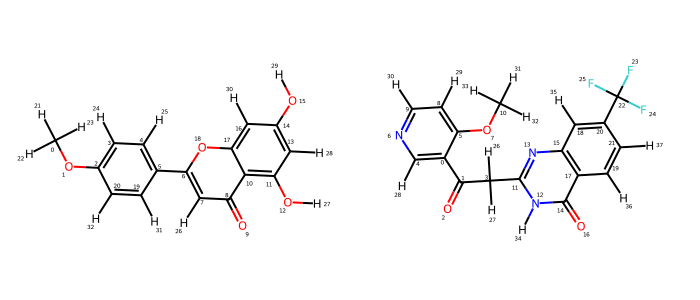

In [30]:
from rdkit.Chem import rdDepictor

rmol2d = Chem.Mol(rmol)
qmol2d = Chem.Mol(qmols[idx])
rdDepictor.Compute2DCoords(rmol2d)
rdDepictor.Compute2DCoords(qmol2d)
IPythonConsole.ShowMols([rmol2d, qmol2d], subImgSize=(350, 300), molsPerRow=2)

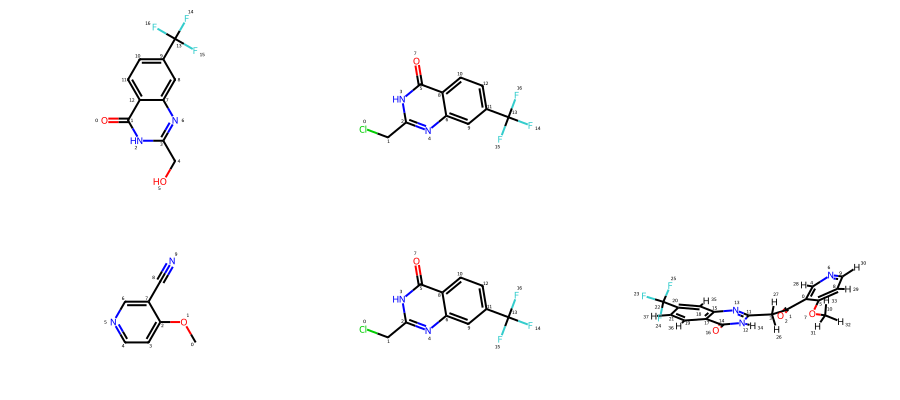

In [31]:
routes[idx].visualize()